# Gallery

In [1]:
import yasa
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Download the EEG data and hypnogram
eeg_filepath = yasa.fetch_sample('full_6hrs_100Hz_Cz+Fz+Pz.npz')
hypno_filepath = yasa.fetch_sample('full_6hrs_100Hz_hypno_30s.txt')

# Load EEG data
npzfile = np.load(eeg_filepath)
data, ch_names = npzfile['data'], npzfile['chan']
sf = 100.

# Load hypnogram
hypno_30s = np.loadtxt(hypno_filepath)
hypno = yasa.hypno_upsample_to_data(hypno=hypno_30s, sf_hypno=(1/30), data=data, sf_data=sf)
print(hypno.shape, 'Unique values =', np.unique(hypno))

28-Dec-24 15:44:12 | WARNING | Hypnogram is SHORTER than data by 10.58 seconds. Padding hypnogram with last value to match data.size.


(2161058,) Unique values = [0. 1. 2. 3. 4.]


### Transition Matrix

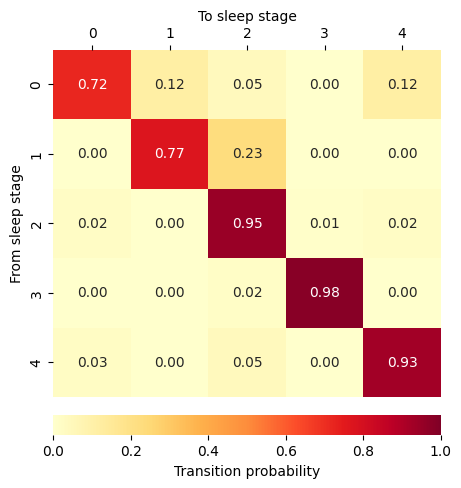

In [2]:
_, probs = yasa.transition_matrix(hypno_30s)

# Start the plot
grid_kws = {"height_ratios": (.9, .05), "hspace": .1}
f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws, figsize=(5, 5))
sns.heatmap(probs, ax=ax, square=False, vmin=0, vmax=1, cbar=True,
            cbar_ax=cbar_ax, cmap='YlOrRd', annot=True, fmt='.2f',
            cbar_kws={"orientation": "horizontal", "fraction": 0.1,
                      "label": "Transition probability"})
ax.set_xlabel("To sleep stage")
ax.xaxis.tick_top()
ax.set_ylabel("From sleep stage")
ax.xaxis.set_label_position('top')
# plt.savefig('transition.png', dpi=100, bbox_inches='tight')

### Spectrogram

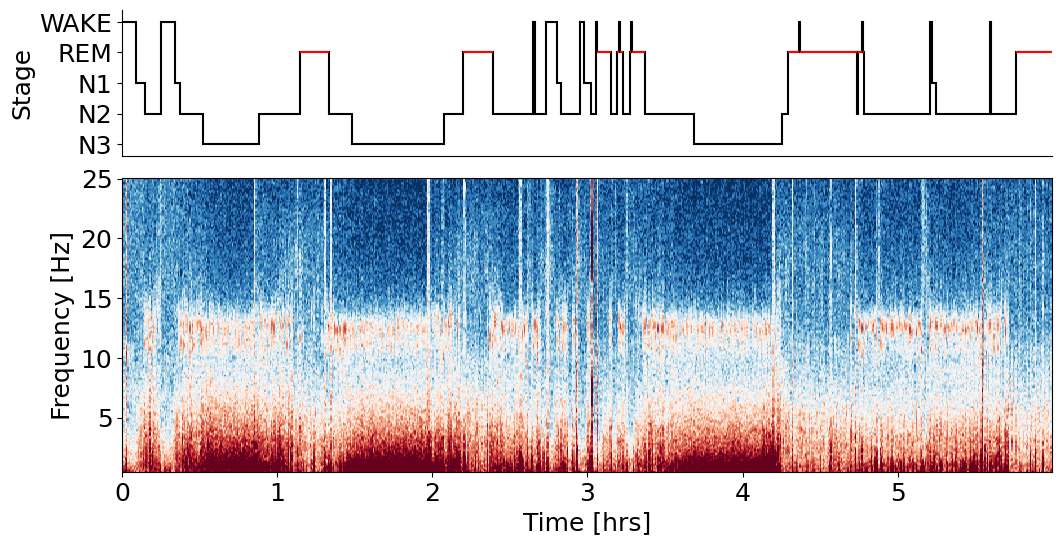

In [3]:
fig = yasa.plot_spectrogram(data[0, :], sf, hypno, trimperc=2.5)
# plt.savefig('spectrogram.png', dpi=100, bbox_inches='tight')

### Topoplot

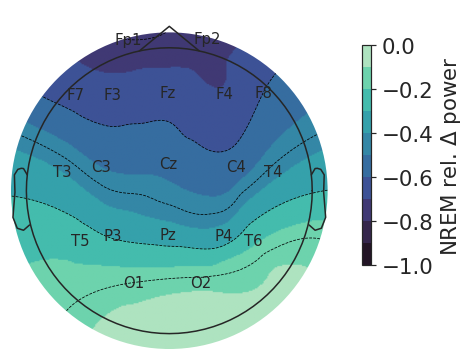

In [4]:
bp = pd.Series({
    "Fp1": 0.75, "Fp2": 0.73, 
    "F7": 0.64, "F3": 0.66, "Fz": 0.65, "F4": 0.69, "F8": 0.60,
    "T3": 0.40, "C3": 0.50, "Cz": 0.53, "C4": 0.55, "T4": 0.43,
    "T5": 0.25, "P3": 0.31, "Pz": 0.35, "P4": 0.35, "T6": 0.22,
    "O1": 0.15, "O2": 0.13,
}, name="Delta")

yasa.topoplot(-1 * bp, vmin=-1, vmax=0, n_colors=10, dpi=110, 
              cbar_title="NREM rel. $\Delta$ power");

### Average spindles and slow-waves

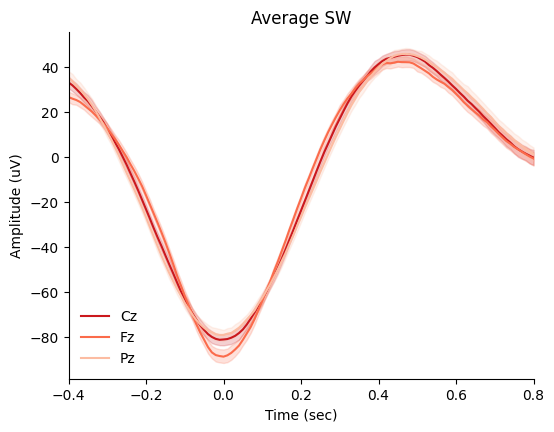

In [5]:
sw = yasa.sw_detect(data, sf, ch_names, hypno, include=(2, 3), coupling=True)
ax = sw.plot_average(palette="Reds_r", errorbar=("ci", 99))
ax.legend(frameon=False)
sns.despine()
# plt.savefig('avgsw.png', dpi=100, bbox_inches='tight')

In [6]:
sw.summary()

,Start,NegPeak,MidCrossing,PosPeak,End,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency,SigmaPeak,PhaseAtSigmaPeak,ndPAC,Stage,Channel,IdxChannel
0,644.28,644.54,644.76,644.96,645.15,0.87,-59.704908,47.278239,106.983147,486.287032,1.149425,644.13,0.584265,0.192233,2,Cz,0
1,645.15,645.37,645.59,645.82,646.03,0.88,-48.098622,48.927376,97.025998,441.027264,1.136364,645.38,-3.027173,0.232610,2,Cz,0
2,646.03,646.26,646.45,646.68,646.88,0.85,-53.666150,70.077959,123.744109,651.284785,1.176471,646.51,-1.170912,0.315951,2,Cz,0
3,646.88,647.08,647.29,647.48,647.71,0.83,-66.642138,52.304780,118.946917,566.413892,1.204819,646.51,-1.170912,0.375062,2,Cz,0
4,648.74,649.06,649.30,649.51,649.73,0.99,-136.856433,97.896853,234.753286,978.138691,1.010101,649.34,-1.364646,0.417661,2,Cz,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6952,20499.71,20500.10,20500.38,20500.69,20501.05,1.34,-78.052036,80.089141,158.141177,564.789918,0.746269,20499.10,2.367345,0.251235,2,Pz,2
6953,20501.05,20501.29,20501.51,20501.76,20502.05,1.00,-41.653859,45.119192,86.773051,394.422961,1.000000,20502.11,1.849059,0.349380,2,Pz,2
6954,20523.82,20524.15,20524.36,20524.62,20524.99,1.17,-64.729587,92.053975,156.783561,746.588387,0.854701,20525.14,1.413392,0.345587,2,Pz,2
6955,20525.61,20526.21,20526.49,20526.76,20527.36,1.75,-80.463754,52.003873,132.467627,473.098666,0.571429,20525.21,0.974229,0.487947,2,Pz,2


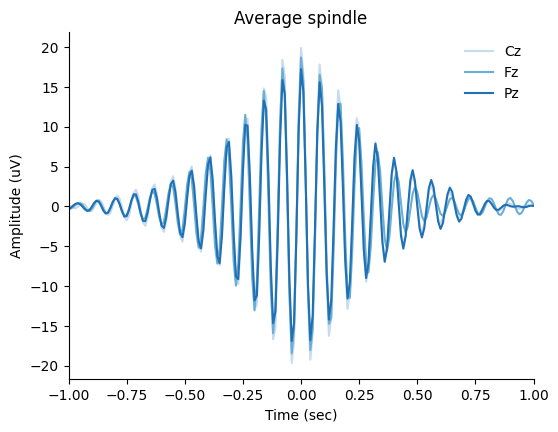

In [7]:
sp = yasa.spindles_detect(data, sf, ch_names, hypno, include=(2))
ax = sp.plot_average(filt=(12, 16), errorbar=None, palette="Blues")
ax.legend(frameon=False)
sns.despine()
# plt.savefig('avgsp.png', dpi=100, bbox_inches='tight')

### SO/spindles coupling

In [8]:
sw.summary(grp_chan=True)

,Count,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency,PhaseAtSigmaPeak,ndPAC
Channel,,,,,,,,,
Cz,2397,1.167238,-76.589084,62.327246,138.916329,534.562030,0.913084,-0.032747,0.299400
Fz,2283,1.154442,-75.250458,59.371057,134.621515,526.679633,0.920225,-0.024827,0.307141
Pz,2277,1.191651,-77.629454,62.711071,140.340525,526.880728,0.895146,-0.148512,0.300715


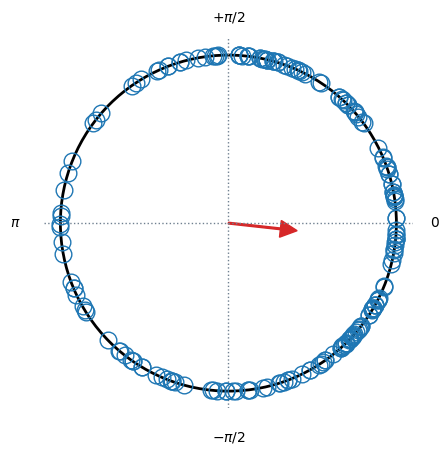

In [9]:
import pingouin as pg
events = sw.summary().query("Channel == 'Fz'").iloc[300:500]
ax = pg.plot_circmean(events['PhaseAtSigmaPeak'], kwargs_markers={'color': 'tab:blue', 'marker': 'o', 'mfc': 'none', 'ms': 12})
# plt.savefig('coupling.png', dpi=100, bbox_inches='tight')

### Comodulogram

WARNING | MVL is amplitude dependent which means that if the amplitude increases, MVL also increases. You should select a normalization method for correcting this limitation (e.g idpac=(1, 2, 4))
28-Dec-24 15:44:44 | WARNING | MVL is amplitude dependent which means that if the amplitude increases, MVL also increases. You should select a normalization method for correcting this limitation (e.g idpac=(1, 2, 4))


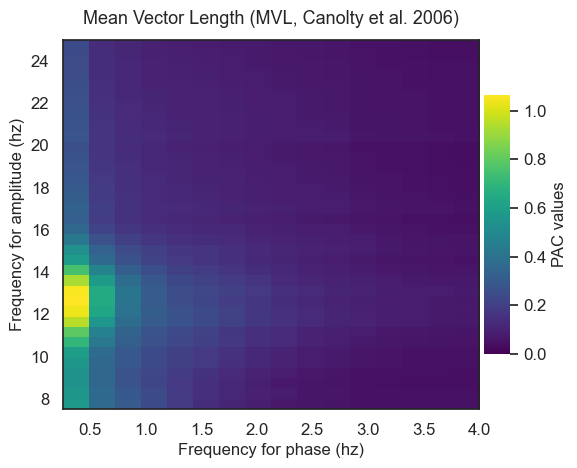

In [10]:
# Segment N2 sleep into 15-seconds  non-overlapping epochs
_, data_N2 = yasa.sliding_window(data[0, hypno == 2], sf, window=15)

# First, let's define our array of frequencies for phase and amplitude
f_pha = np.arange(0.125, 4.25, 0.25)  # Frequency for phase
f_amp = np.arange(7.25, 25.5, 0.5)  # Frequency for amplitude

from tensorpac import Pac
sns.set_theme(font_scale=1.1, style='white')

# Define a PAC object
p = Pac(idpac=(1, 0, 0), f_pha=f_pha, f_amp=f_amp, verbose='WARNING')

# Filter the data and extract the PAC values
xpac = p.filterfit(sf, data_N2)

# Plot the comodulogram
p.comodulogram(xpac.mean(-1), title=str(p), vmin=0, plotas='imshow');
# plt.savefig('comod.png', dpi=100, bbox_inches='tight')

### Overlay

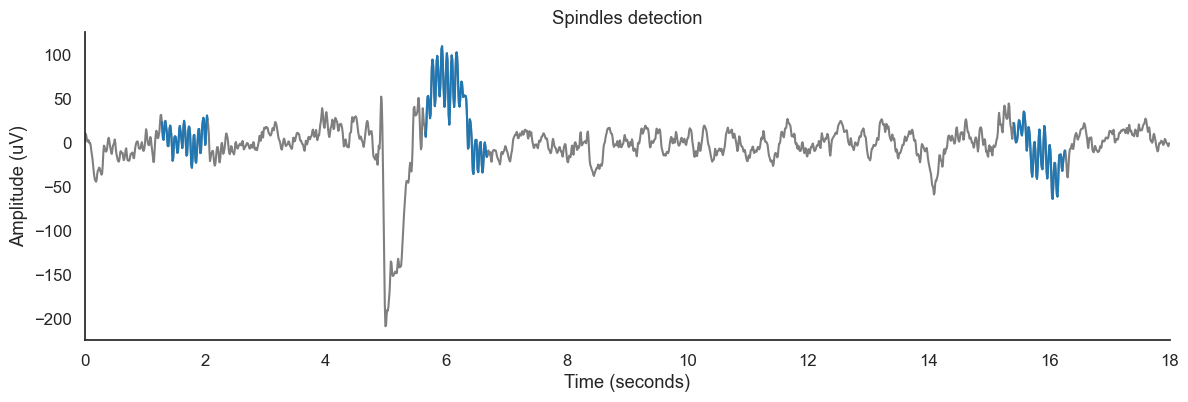

In [11]:
# Keep only 30-seconds of data
import mne
data_N2 = data[0, int(18164 * sf):int(18182 * sf)].astype(np.float64)
data_N2 = mne.filter.filter_data(data_N2, sf, 0.5, 30, verbose=False)

times_N2 = np.arange(data_N2.size) / sf

# Spindles detection
sp = yasa.spindles_detect(data_N2, sf)
events = sp.summary()
mask = sp.get_mask()

# Plot the signal
spindles_highlight = data_N2 * mask
spindles_highlight[spindles_highlight == 0] = np.nan

fig, ax = plt.subplots(1, 1, figsize=(14, 4))
plt.plot(times_N2, data_N2, lw=1.5, color='tab:grey')
plt.plot(times_N2, spindles_highlight, lw=1.5, color='tab:blue')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (uV)')
plt.xlim([0, times_N2[-1]])
plt.xticks(np.arange(0, 19, 2))
plt.title('Spindles detection')
sns.despine()
# plt.savefig('spoverlay.png', dpi=100, bbox_inches='tight')

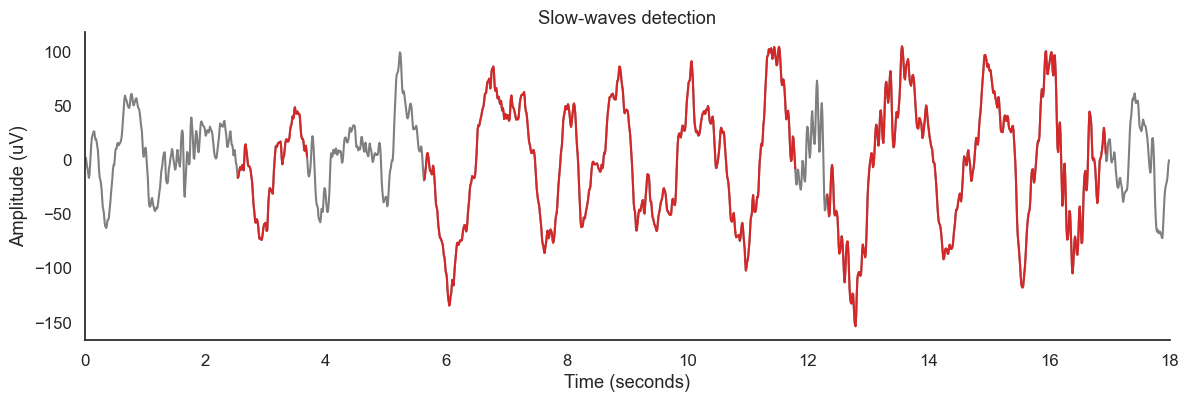

In [12]:
# Keep only 30-seconds of data
data_N3 = data[0, int(14105 * sf):int(14123 * sf)].astype(np.float64)
times_N3 = np.arange(data_N3.size) / sf
data_N3 = mne.filter.filter_data(data_N3, sf, 0.5, 30, verbose=False)

# Slow-waves detection
sw = yasa.sw_detect(data_N3, sf)
events = sw.summary()
mask = sw.get_mask()

# Plot the signal
sw_highlight = data_N3 * mask
sw_highlight[sw_highlight == 0] = np.nan

fig, ax = plt.subplots(1, 1, figsize=(14, 4))
plt.plot(times_N3, data_N3, lw=1.5, color='tab:grey')
plt.plot(times_N3, sw_highlight, lw=1.5, color='tab:red')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (uV)')
plt.xlim([0, times_N3[-1]])
plt.xticks(np.arange(0, 19, 2))
plt.title('Slow-waves detection')
sns.despine()
# plt.savefig('swoverlay.png', dpi=100, bbox_inches='tight')